In [2]:
from os import path

from astropy.constants import m_p
import astropy.coordinates as coord
from astropy.table import Table, join
import astropy.units as u
from astropy.io import fits

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import center_emph, center_deemph

In [3]:
galcen_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc, z_sun=0*u.pc, 
                                    galcen_v_sun=coord.CartesianDifferential(11.1, 232.24, 7.25, unit=u.km/u.s))

In [40]:
mike_data = Table.read('../data/mike_final.fits')
mike_data['pw1_id'] = [int(x.strip()[-2:]) if 'pw' in x else 9999 for x in mike_data['NAME']]

data = Table.read('../output/pw1-region-data-joined.fits')
data['pw1_id'] = [int(x.strip()[-2:]) if 'PW' in x else 9999 for x in data['pw1_name']]

In [41]:
tbl = join(data, mike_data, keys='pw1_id')
tbl = tbl[tbl['pw1_name'] != '']

In [42]:
all_c = coord.SkyCoord(ra=tbl['ra']*u.deg,
                       dec=tbl['dec']*u.deg,
                       distance=28.7*u.kpc,
                       pm_ra_cosdec=tbl['pmra']*u.mas/u.yr,
                       pm_dec=tbl['pmdec']*u.mas/u.yr,
                       radial_velocity=tbl['VHELIO']*u.km/u.s)

Mean cluster kinematics determined using the velocity model in `Kinesis-model.ipynb`

In [509]:
avg_c = coord.SkyCoord(ra=178.94196721*u.deg, 
                       dec=-29.41088227*u.deg, 
                       distance=28.7*u.kpc,
                       pm_ra_cosdec=-0.52*u.mas/u.yr,
                       pm_dec=0.42*u.mas/u.yr,
                       radial_velocity=249.1*u.km/u.s).transform_to(galcen_frame)

In [510]:
galcen = avg_c.transform_to(galcen_frame)
w0 = gd.PhaseSpacePosition(galcen.data)
pot = gp.MilkyWayPotential()

Compute the orbit in a Milky Way model without drag by integrating backwards in time:

In [511]:
orbit_nodrag = pot.integrate_orbit(w0, dt=-0.1, n_steps=2000)

Find the "intital conditions" at the inferred age of the cluster (-130 Myr):

In [512]:
age = 130 * u.Myr
w0_birth = orbit_nodrag[np.abs(orbit_nodrag.t - -age).argmin()]
t_birth = orbit_nodrag.t[np.abs(orbit_nodrag.t - -age).argmin()]
t_birth

<Quantity -130. Myr>

Estimate the drag acceleration by assuming a cloud surface density, milky way gas density, then use:

$$
a_{\rm ram} = \rho_{\rm MW} \, v^2 \, m_H^{-1} \, \Sigma_{cloud}^{-1}
$$

For the cloud surface density, try plugging in the column density of the LA gas. David gave me:

In [518]:
col_dens = 7 * 10**19 * 1 / u.cm**2
surf_dens = (col_dens * m_p).to_value(u.Msun / u.kpc**2)
(col_dens * m_p).to(u.Msun / u.pc**2)

<Quantity 0.56063045 solMass / pc2>

In [519]:
# for unit conversion
_dens_fac = m_p.to_value(u.Msun) * (1/u.cm**3).to_value(1/u.kpc**3)

In [560]:
Rsun = 8.1 # * u.kpc

# A model for the number density of the halo:
def n_mw_halo(r):
    # From Miller & Bregman 2013
    n0 = 0.46 # / u.cm**3
    rc = 0.35 # * u.kpc
    beta = 0.71
    return n0 * (1 + (r/rc)**2) ** (-1.5 * beta)


# A model for the number density of the disk:
# - Note: it flares as a function of radius, so need a 
#   function to compute the scale height at a given R
def sigz(R):
    h0 = 0.15 # * u.kpc
    R0 = 9.8 # * u.kpc
    hz = h0 * np.exp((R-Rsun) / R0)
    return 0.85 * hz
    
def n_mw_disk(R, z):
    # From Kaberla review
    s = sigz(R)
    
    n0 = 0.9 # / u.cm**3
    Rn = 3.15 # * u.kpc
    
    # note: I added the z dependence
    return n0 * np.exp(-(R-Rsun)/Rn) * np.exp(-0.5 * z**2 / s**2)

In [561]:
# For playing around with a time-evolving surface density...ignore
def surf_dense_func(t, t1, t2):
    surf_dens0 = np.log(50.)
    surf_densf = np.log(0.5)
    m = (surf_densf - surf_dens0) / (t2 - t1)
    return np.exp(m * t + surf_densf)

Fudge factors that we multiple the drag force by for the halo and disk terms:

In [562]:
magic_factor_halo = 1.
# magic_factor_disk = 0. # turn off the disk component
magic_factor_disk = 0.5

In [621]:
# surf_dens = 1e6 * surf_dense_func(t, t_zeq0.value, 0.)

def F(t, w):
    # position units are in kpc
    # velocity units here are in kpc/Myr
    x, y, z, vx, vy, vz = w
    
    q = np.stack((x, y, z), axis=1)
    p = np.stack((vx, vy, vz), axis=1)
    
    r = np.linalg.norm(q) # galcen distance
    R = np.sqrt(x**2 + y**2)[0] # cylindrical radius
    
    # compute acceleration from milky way:
    _t = np.array([0.])
    acc = -pot._gradient(q, _t).T
    
    # compute drag acceleration    
    nn = magic_factor_halo * n_mw(r) + magic_factor_disk * n_mw_disk(R, z)
    fac = (nn * _dens_fac) / surf_dens
    acc_drag = fac * np.sum(p**2, axis=1) # rho / Sigma * v^2
    
    # in the direction opposite of motion
    acc_drag = -acc_drag * p / np.sqrt(np.sum(p**2, axis=1))
    acc_drag = acc_drag.T
    
    # ---
    coupling_factor = 2e-2
    
    # the Cartesian unit vector in the direction of galactic rotation 
    # at the current position of the orbit
    phi = np.arctan2(y[0], x[0])
    unit_vec = -np.array([-np.sin(phi), np.cos(phi), 0])
    
    # multiply by a gaussian so this only operates near the midplane
    acc_drag[:, 0] += coupling_factor * unit_vec * np.exp(-0.5 * z[0]**2 / sigz(R)**2)
    
    return np.vstack((p.T, acc + acc_drag))

In [622]:
integrator = gi.DOPRI853Integrator(F, func_units=galactic)
orbit_drag = integrator.run(w0_birth, dt=0.1, t1=-age, t2=0)

Text(0, 0.5, '$z$ [kpc]')

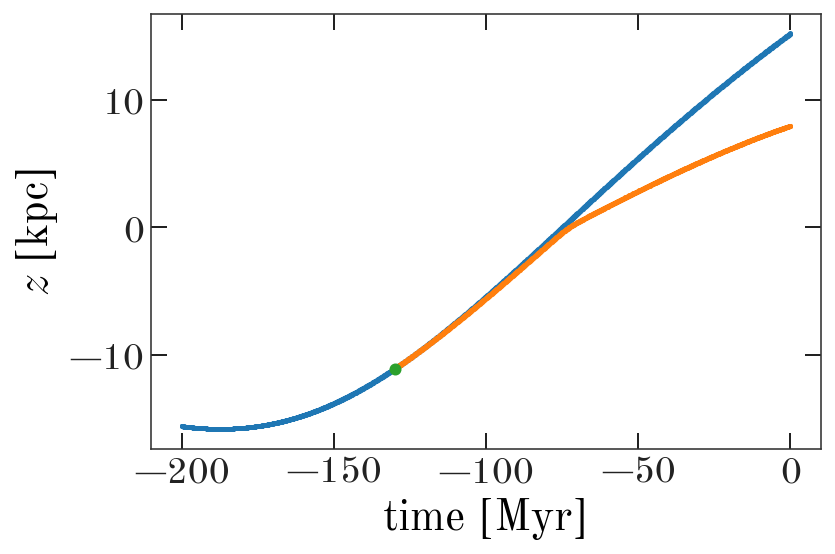

In [625]:
plt.plot(orbit_nodrag.t, orbit_nodrag.z)
plt.plot(orbit_drag.t, orbit_drag.z)
plt.scatter(t_birth, w0_birth.z, color='tab:green', zorder=100)

plt.xlabel(r'time [Myr]')
plt.ylabel(r'$z$ [kpc]')

In [626]:
orbit_nodrag_c = orbit_nodrag.to_coord_frame(gc.MagellanicStreamNidever08, 
                                             galactocentric_frame=galcen_frame)
orbit_drag_c = orbit_drag.to_coord_frame(gc.MagellanicStreamNidever08, 
                                         galactocentric_frame=galcen_frame)

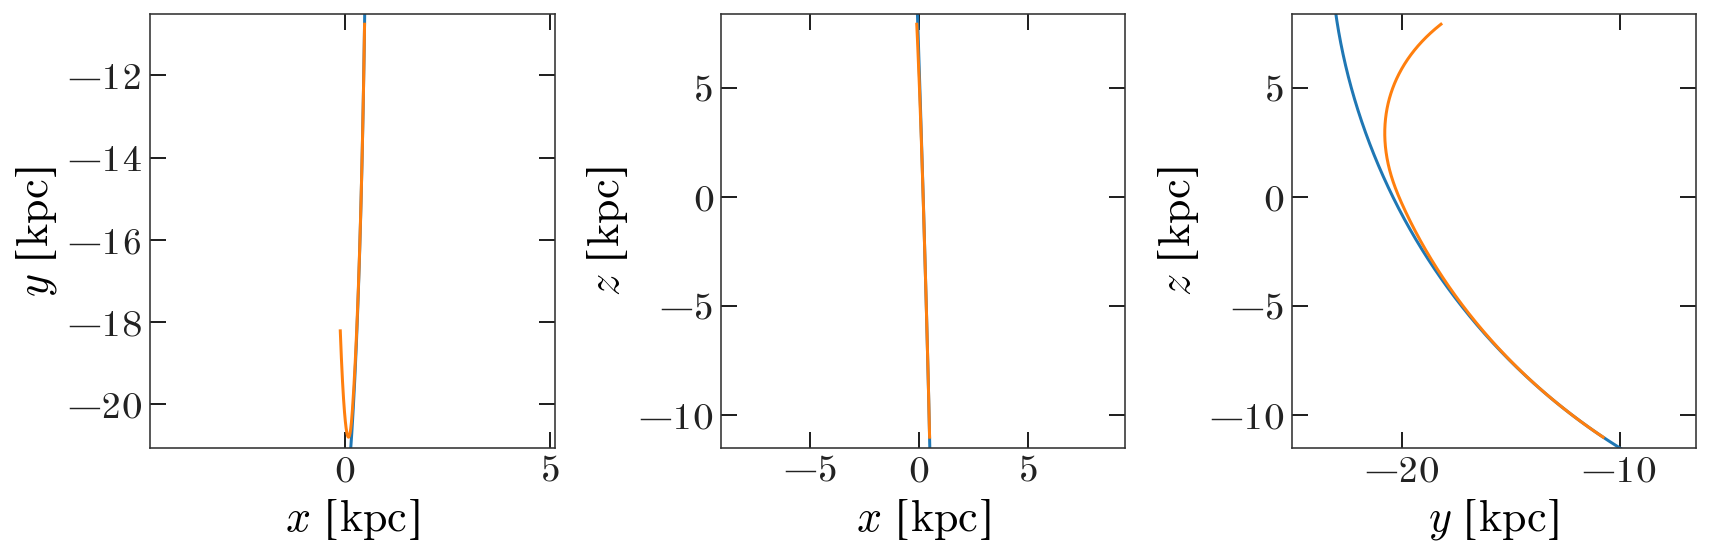

In [627]:
fig = orbit_nodrag.plot()
_ = orbit_drag.plot(axes=fig.axes)

Text(0, 0.5, '$RV$ [$\\mathrm{km\\,s^{-1}}$]')

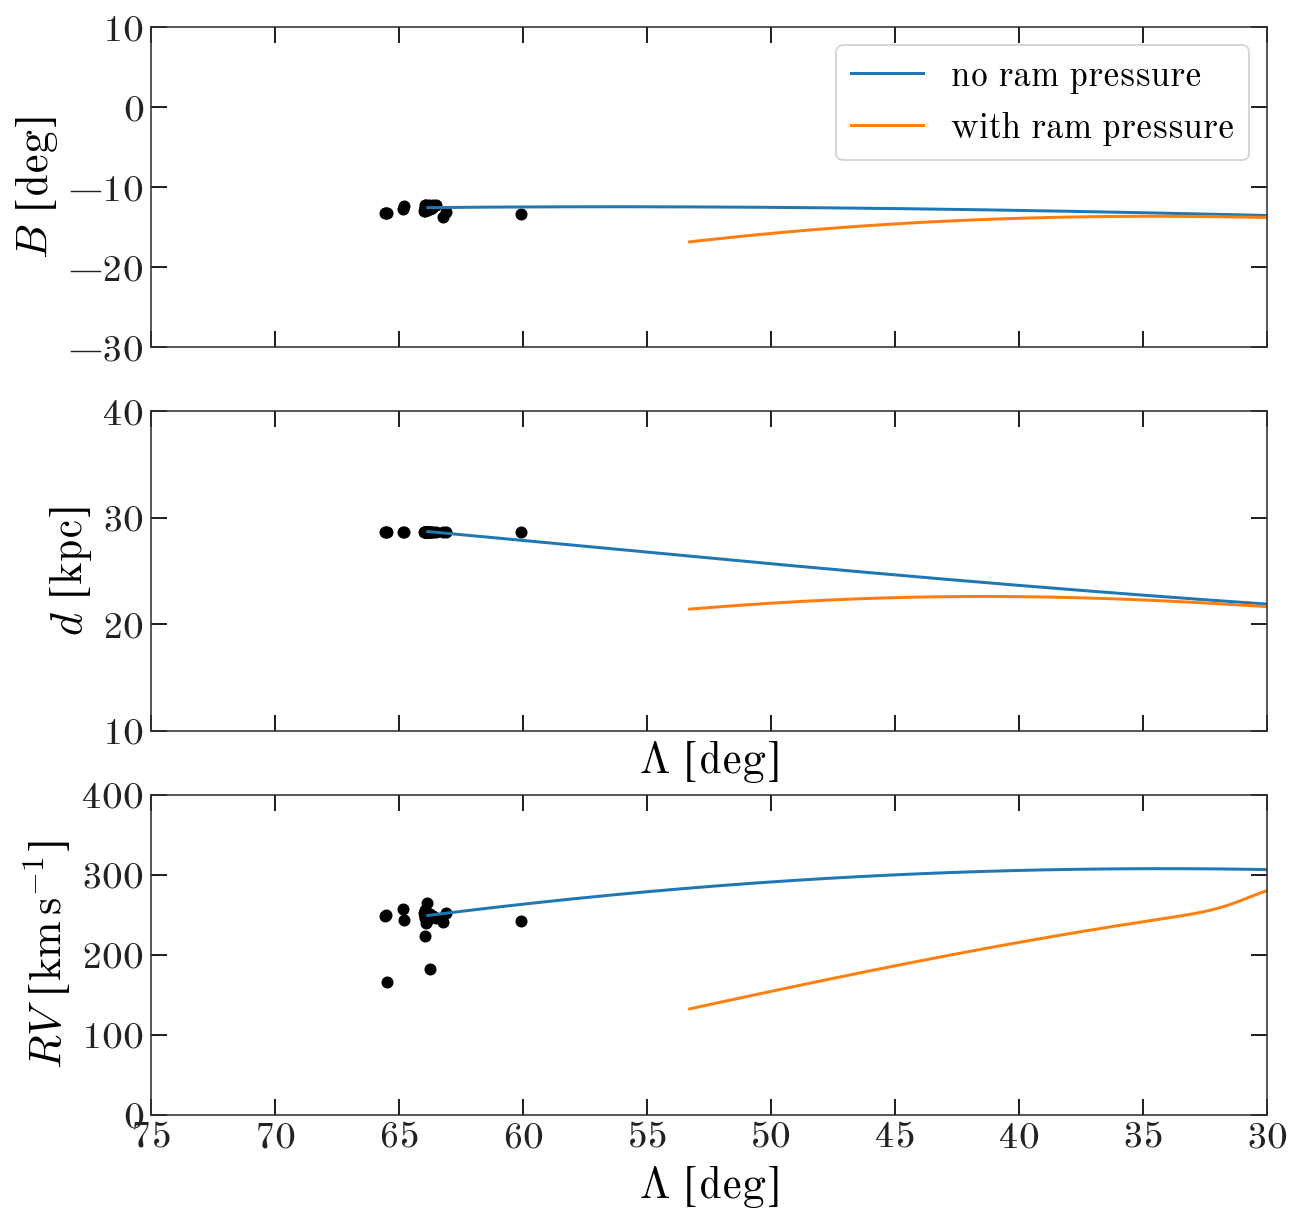

In [628]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), 
                         sharex=True)

ax = axes[0]
mag_clump_c = clump_c.transform_to(gc.MagellanicStreamNidever08)
ax.scatter(mag_clump_c.L.degree, mag_clump_c.B.degree, marker='o', color='k')

ax.plot(orbit_nodrag_c.L.degree, orbit_nodrag_c.B.degree, marker='', label='no ram pressure')
ax.plot(orbit_drag_c.L.degree, orbit_drag_c.B.degree, marker='', label='with ram pressure')

ax.legend(loc='best', fontsize=18)

ax.set_xlim(75, 30)
ax.set_ylim(-30, 10)

ax.set_ylabel(r'$B$ [deg]')

# ---

ax = axes[1]
ax.scatter(mag_clump_c.L.degree, mag_clump_c.distance.value, marker='o', color='k')

ax.plot(orbit_nodrag_c.L.degree, orbit_nodrag_c.distance.value, marker='')
ax.plot(orbit_drag_c.L.degree, orbit_drag_c.distance.value, marker='')

ax.set_xlim(75, 30)
ax.set_ylim(10, 40)

ax.set_xlabel(r'$\Lambda$ [deg]')
ax.set_ylabel(r'$d$ [kpc]')

# ---

ax = axes[2]
ax.scatter(mag_clump_c.L.degree, mag_clump_c.radial_velocity.value, marker='o', color='k')

ax.plot(orbit_nodrag_c.L.degree, orbit_nodrag_c.radial_velocity.value, marker='')
ax.plot(orbit_drag_c.L.degree, orbit_drag_c.radial_velocity.value, marker='')

ax.set_xlim(75, 30)
ax.set_ylim(0, 400)

ax.set_xlabel(r'$\Lambda$ [deg]')
ax.set_ylabel(r'$RV$ [{:latex_inline}]'.format(u.km/u.s))

# fig.savefig('../plots/with-gas-disk.png', dpi=250)